In [1]:
ENV["JULIA_PKG_SERVER"] = ""
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using TableTransforms

  Activating project at `~/Documents/GitHub/Imbalance.jl/examples`


### 1. Generate Random Data

In [2]:
rng = Random.default_rng()

type="ColTable"
num_rows = 50
num_features = 5
class_probs = [0.5, 0.2, 0.3]
y_ind = 3

Xy, _ = generate_imbalanced_data(num_rows, num_features; class_probs, type, insert_y=y_ind, rng=42)
X, y = generate_imbalanced_data(num_rows, num_features; class_probs, type, rng=42)

((Column1 = [0.02103670114176867, 0.01203656826551918, -0.028724090946783173, -0.026067798548702552, 0.4896814551165388, -0.06960423536690308, -0.010062468927638138, 0.9300451333496398, 0.6920019205374721, 0.03178854455124758  …  0.6403938659654876, -0.01280936007613933, 0.7967256141487284, 0.04652380931595733, 0.017541655327617867, 0.37215510528075335, 0.31871768144972346, 0.09505894684463774, 0.7406101242224754, 0.11850826307238704], Column2 = [0.045805672318605044, 0.1795542071532961, 0.19029160661749647, 0.33022806439292995, 1.0732436152025253, -0.02730294804501472, -0.030273317171456815, 1.6050231139128013, 1.728120174391614, 0.187323438623752  …  1.7973416633619632, -0.02498855536190217, 1.7948275054836789, 0.21055075869216572, 0.26842128896843775, 1.6384536151975515, 1.0296034007529251, 0.33425327741295974, 1.516682656290371, 0.16623938335698535], Column3 = [0.48646053535754885, 0.644816251849692, 0.7325405420710099, 0.4425645585780982, 0.3676955891110373, 0.6850779700419444, 0.

### 2. Apply ROSE

#### Using Imbalance Only

In [3]:
Xover, yover = rose(X, y; s = 0.3, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01



Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  class:  2


((Column1 = [0.02103670114176867, 0.01203656826551918, -0.028724090946783173, -0.026067798548702552, 0.4896814551165388, -0.06960423536690308, -0.010062468927638138, 0.9300451333496398, 0.6920019205374721, 0.03178854455124758  …  0.37693306365082163, 0.7937862736530742, 0.46160373175197733, 0.9180962493753599, 0.41061880023322894, 0.8904038656547419, 0.37188084712000796, 0.6336282425187573, 0.6716875189346009, 0.771090810959432], Column2 = [0.045805672318605044, 0.1795542071532961, 0.19029160661749647, 0.33022806439292995, 1.0732436152025253, -0.02730294804501472, -0.030273317171456815, 1.6050231139128013, 1.728120174391614, 0.187323438623752  …  1.7530394997132885, 1.8083933127013718, 2.23208889766702, 1.6350306413674642, 1.5116637066410616, 1.7699100389794187, 1.6470862491308595, 1.8810739819961315, 1.8477047344767794, 1.7894712369327284], Column3 = [0.48646053535754885, 0.644816251849692, 0.7325405420710099, 0.4425645585780982, 0.3676955891110373, 0.6850779700419444, 0.6211617375532

#### Using MLJ

In [4]:
rose_model = Imbalance.MLJ.ROSE(s=0.09, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(rose_model)
Xover, yover = transform(mach, X, y)

((Column1 = [0.02103670114176867, 0.01203656826551918, -0.028724090946783173, -0.026067798548702552, 0.4896814551165388, -0.06960423536690308, -0.010062468927638138, 0.9300451333496398, 0.6920019205374721, 0.03178854455124758  …  0.4325366623248021, 0.7958438120000322, 0.4970995799696548, 0.9264604681573558, 0.387129186186269, 0.8248290896005325, 0.37207282783252976, 0.6377061765785232, 0.6491239595032764, 0.7890351731919395], Column2 = [0.045805672318605044, 0.1795542071532961, 0.19029160661749647, 0.33022806439292995, 1.0732436152025253, -0.02730294804501472, -0.030273317171456815, 1.6050231139128013, 1.728120174391614, 0.187323438623752  …  1.7755723066414493, 1.7988972476489868, 2.204114803545339, 1.6140253721492002, 1.5407078645453676, 1.7873522655324008, 1.641043405377544, 1.849413984601754, 1.8394032103459486, 1.7932206249183937], Column3 = [0.48646053535754885, 0.644816251849692, 0.7325405420710099, 0.4425645585780982, 0.3676955891110373, 0.6850779700419444, 0.6211617375532913,

#### Using TableTransforms

In [5]:
using Imbalance: TableTransforms.ROSE
rose_model_t = ROSE(y_ind, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
apply(rose_model_t, Xy)

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:00



Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  class:  2.0


((Column1 = [-0.04983240612868138, 0.052428872903093976, 0.012282031389832505, 0.05949591468398563, 0.17278992541726168, 0.05931826953371829, 0.05953975919171735, 0.8957983482095846, 0.6534796696563004, 0.025066128623331192  …  0.3602334228595501, 0.612079696727068, 0.3501243575658215, 0.8624235972553754, 0.6317959544220815, 0.8819449057116087, 0.6086541673366462, 0.6257454671110362, 0.7320498612795925, 0.5486883861392936], Column2 = [0.2623815990141598, 0.02194108897059069, 0.0671443474521535, 0.12574696103012603, 1.0963647418191287, 0.15221215143194564, 0.034560218913928936, 1.6389706895278562, 1.6858123152269338, -0.16528185070250662  …  2.05438487674326, 1.5912407606072956, 1.6856348962293093, 1.7172131340971124, 1.777141644562223, 1.4908984243190868, 1.6961529152403105, 1.637192064976219, 1.5501841799281966, 1.5419028247610247], Column3 = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], Column4 = [0.5859979160732698, 0.878531

### 3. Plot the Results

    Updating registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


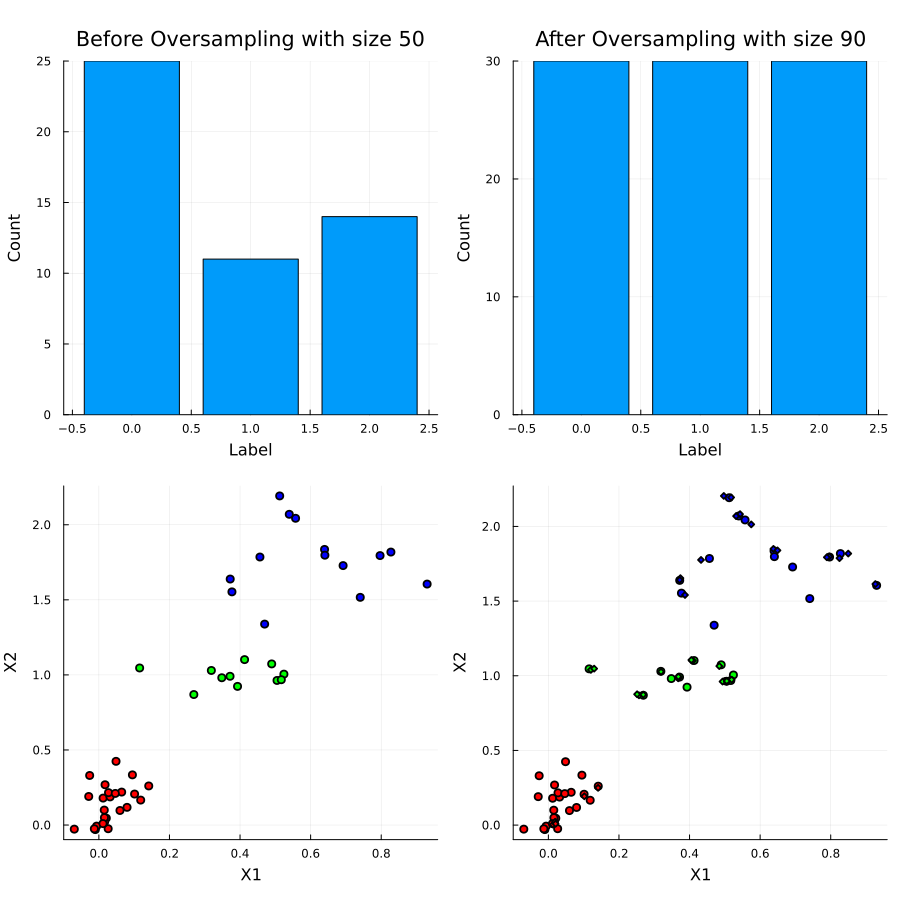

In [6]:
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, yover, X, Xover)